# Stories Dataset

Лаботоратория по искусственному интеллекту, Сбербанк. 

Авторы: [Борис Шминке](<mailto:Shminke.B.A@omega.sbrf.ru>), [Роза Айсина](<mailto:Aysina.R.M@omega.sbrf.ru>). 

О чем: применение рекомендательных систем к датасету историй. Схема разбиения - делим лог на две рандомные части.

## Содержание

1. [Импорты, создание спарк-сессии](#intro)
2. [Подготовка данных](#data-preparator)
3. [Рекомендатель на основе популярности](#popular-recommender)
3.1. [Запуск single модели](#popular-recommender-single)
3.2. [Подбор гиперпараметров](#popular-recommender-scenario)
4. [Рекомендатель на основе k-NN для объектов](#knn-recommender)
4.1. [Запуск single модели](#knn-recommender-single)
4.2. [Подбор гиперпараметров](#knn-recommender-scenario)

### Импорты, создание спарк-сессии <a name='intro'></a>

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging
import os
import re
import sys
from collections import Counter
from datetime import datetime
from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql import functions as sf
from sklearn.feature_extraction.text import CountVectorizer

In [3]:
parent_dir = os.path.split(os.getcwd())[0]
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

In [4]:
from sponge_bob_magic.data_preparator.data_preparator import DataPreparator
from sponge_bob_magic.metrics.metrics import Metric
from sponge_bob_magic.models.popular_recomennder import PopularRecommender
from sponge_bob_magic.models.knn_recommender import KNNRecommender
from sponge_bob_magic.scenarios.knn_scenario import KNNScenario
from sponge_bob_magic.scenarios.popular_scenario import PopularScenario
from sponge_bob_magic.validation_schemes.validation_schemes import ValidationSchemes

In [5]:
# отображение максимальной ширины колонок в pandas датафреймах
pd.options.display.max_colwidth = -1

In [5]:
spark_memory = "200g"
spark_cores = "50"
user_home = "/datascc/aysina-rm"

spark = (
    SparkSession
    .builder
    .config('spark.driver.memory', spark_memory)
    .config('spark.local.dir', os.path.join(user_home, "tmp"))
    .master(f'local[{spark_cores}]')
    .enableHiveSupport()
    .getOrCreate()
)

spark

In [6]:
spark_logger = logging.getLogger('py4j')
spark_logger.setLevel(logging.WARN)

In [7]:
logger = logging.getLogger()
formatter = logging.Formatter('%(asctime)s, %(name)s, %(levelname)s: %(message)s',
                              datefmt='%d-%b-%y %H:%M:%S')
hdlr = logging.StreamHandler()
hdlr.setFormatter(formatter)
logger.addHandler(hdlr)
logger.setLevel(logging.DEBUG)

## Подготовка данных <a name='data-preparator'></a>

In [8]:
path_log = '/datascc/share/stories_data'

In [9]:
dp = DataPreparator(spark)

In [10]:
df = dp.transform_log(
    path=path_log,
    format_type="csv",
    columns_names={
        "user_id": "_c1",
        "item_id": "_c2",
        "timestamp": "_c0",
        "relevance": "_c3"
    }
).cache()

In [11]:
df.show(3)

+---------+-------+-------------------+---------+----------+
|  user_id|item_id|          timestamp|relevance|   context|
+---------+-------+-------------------+---------+----------+
|111715824|   1174|2019-07-19 00:00:00|   2896.0|no_context|
|430734041|  12093|2019-07-19 00:00:00|   4073.0|no_context|
|150084873|  12093|2019-07-19 00:00:00|  16462.0|no_context|
+---------+-------+-------------------+---------+----------+
only showing top 3 rows



In [12]:
df.count()

64735941

In [13]:
df.agg(*(sf.countDistinct(sf.col(c)).alias(c) for c in df.columns)).show()

+--------+-------+---------+---------+-------+
| user_id|item_id|timestamp|relevance|context|
+--------+-------+---------+---------+-------+
|14691326|   1445|      229|   571566|      1|
+--------+-------+---------+---------+-------+



In [14]:
df.agg(sf.min(sf.col("timestamp")), sf.max(sf.col("timestamp"))).show()

+-------------------+-------------------+
|     min(timestamp)|     max(timestamp)|
+-------------------+-------------------+
|2019-02-13 00:00:00|2019-09-29 00:00:00|
+-------------------+-------------------+



In [15]:
df_short = df.limit(1000).cache()

## Рекомендатель на основе популярности (popularity based recommender) <a name='popular-recommender'></a>

### Запуск single модели <a name='popular-recommender-single'></a>

In [17]:
splitter = ValidationSchemes(spark)

train, test_input, test = splitter.log_split_by_date(
    df, test_start=datetime(2019, 8, 1),
    drop_cold_users=False, drop_cold_items=True
)

(
    train.count(), 
    test_input.count(), 
    test.count()
)

(42534961, 42534961, 16863084)

In [18]:
pr = PopularRecommender(spark, alpha=0, beta=0)

In [19]:
%%time

pr.fit(
    log=train,
    user_features=None,
    item_features=None,
    path=None
)

31-Oct-19 15:19:00, root, DEBUG: Проверка датафреймов
31-Oct-19 15:19:00, root, DEBUG: Предварительная стадия обучения (pre-fit)
31-Oct-19 15:19:04, root, DEBUG: Среднее количество items у каждого user: 5.0
31-Oct-19 15:19:04, root, DEBUG: Основная стадия обучения (fit)


CPU times: user 20 ms, sys: 4 ms, total: 24 ms
Wall time: 4.29 s


In [20]:
%%time

recs = pr.predict(
    k=100,
    users=test.select('user_id').distinct(),
    items=test.select('item_id').distinct(),
    context='no_context',
    log=train,
    user_features=None,
    item_features=None,
    to_filter_seen_items=True,
    path=None
).cache()

31-Oct-19 15:19:04, root, DEBUG: Проверка датафреймов
31-Oct-19 15:19:17, root, DEBUG: Количество items после фильтрации: 105


CPU times: user 28 ms, sys: 4 ms, total: 32 ms
Wall time: 13.3 s


In [21]:
recs.show(5)

+-------+---------+----------+--------------------+
|item_id|  user_id|   context|           relevance|
+-------+---------+----------+--------------------+
|   1040|100080028|no_context|0.020072640950581803|
|  12093|100080028|no_context|0.018805471574312716|
|   1066|100080028|no_context| 0.01427225947144985|
|   1034|100080028|no_context|0.012174103086635015|
|  12048|100080028|no_context|0.011472515514943108|
+-------+---------+----------+--------------------+
only showing top 5 rows



In [22]:
%%time

metric = Metric.hit_rate_at_k(recs, df, k=100)
metric

CPU times: user 24 ms, sys: 12 ms, total: 36 ms
Wall time: 3min


0.2872140986468791

### Подбор гиперпараметров в популярной модели <a name='popular-recommender-scenario'></a>

Популярность объекта определяется как: 

$$ popularity(i) = \dfrac{N_i + \alpha}{N + \beta}, $$

где $ N_i $ &mdash; количество пользователей, у которых было взаимодействие с данным объектом $ i $, 
$ N $ &mdash; общее количество пользователей, которые как провзаимодействовали с объектом, так и нет,
$ \alpha, \beta \in [0, \infty) $ &mdash; параметры модели. 

Эвристика: размуным пределом для параметров $ \alpha $ и $ \beta $ может стать среднее значение количества пользователей $ N_i $, которые провзаимодействовали с объектами.

In [23]:
avg_num_users = (
    df
    .select('user_id', 'item_id')
    .groupBy('item_id')
    .count()
    .select(sf.mean(sf.col('count')).alias('mean'))
    .collect()[0]['mean']
)

avg_num_users

44799.95916955017

In [24]:
popular_scenario = PopularScenario(spark)
popular_scenario.seed = 9876

popular_params_grid = {
    'alpha': (0, 40000), 
    'beta': (0, 40000)
}

In [42]:
%%time

best_params = popular_scenario.research(
    popular_params_grid,
    df,
    users=None, items=None,
    user_features=None,
    item_features=None,
    test_start=None,
    test_size=0.3,
    k=15, context='no_context',
    to_filter_seen_items=True,
    n_trials=1, 
    n_jobs=1,
    how_to_split='randomly'
)

best_params

31-Oct-19 12:39:10, root, DEBUG: Деление на трейн и тест
31-Oct-19 12:39:10, root, DEBUG: Длина трейна и теста: (45317825, 19418087)
31-Oct-19 12:39:12, root, DEBUG: Количество юзеров в трейне и тесте: 12784298, 8421206
31-Oct-19 12:39:13, root, DEBUG: Количество айтемов в трейне и тесте: 1425, 1339
31-Oct-19 12:39:13, root, DEBUG: Популярная модель: полное обучение
31-Oct-19 12:39:13, root, DEBUG: Проверка датафреймов
31-Oct-19 12:39:14, root, DEBUG: Предварительная стадия обучения (pre-fit)
31-Oct-19 12:39:17, root, DEBUG: Среднее количество items у каждого user: 4.0
31-Oct-19 12:39:17, root, DEBUG: Основная стадия обучения (fit)
31-Oct-19 12:39:17, root, DEBUG: -------------
31-Oct-19 12:39:17, root, DEBUG: Начало оптимизации параметров
31-Oct-19 12:39:17, root, DEBUG: -- Параметры: {'alpha': 0, 'beta': 0}
31-Oct-19 12:39:17, root, DEBUG: -- Предикт модели в оптимизации
31-Oct-19 12:39:17, root, DEBUG: Проверка датафреймов
31-Oct-19 12:39:18, root, DEBUG: Количество items после филь

CPU times: user 244 ms, sys: 68 ms, total: 312 ms
Wall time: 2min 9s


{'alpha': 0, 'beta': 0}

In [35]:
%%time

best_params = popular_scenario.research(
    popular_params_grid,
    df,
    users=None, items=None,
    user_features=None,
    item_features=None,
    test_start=None,
    test_size=0.3,
    k=15, context='no_context',
    to_filter_seen_items=True,
    n_trials=15, 
    n_jobs=1,
    how_to_split='randomly'
)

best_params

31-Oct-19 12:08:49, root, DEBUG: Деление на трейн и тест
31-Oct-19 12:08:50, root, DEBUG: Длина трейна и теста: (45317825, 19418087)
31-Oct-19 12:08:52, root, DEBUG: Количество юзеров в трейне и тесте: 12784298, 8421206
31-Oct-19 12:08:53, root, DEBUG: Количество айтемов в трейне и тесте: 1425, 1339
31-Oct-19 12:08:53, root, DEBUG: Популярная модель: полное обучение
31-Oct-19 12:08:53, root, DEBUG: Проверка датафреймов
31-Oct-19 12:08:53, root, DEBUG: Предварительная стадия обучения (pre-fit)
31-Oct-19 12:08:55, root, DEBUG: Среднее количество items у каждого user: 4.0
31-Oct-19 12:08:55, root, DEBUG: Основная стадия обучения (fit)
31-Oct-19 12:08:55, root, DEBUG: -------------
31-Oct-19 12:08:55, root, DEBUG: Начало оптимизации параметров
31-Oct-19 12:08:55, root, DEBUG: -- Параметры: {'alpha': 14178, 'beta': 31200}
31-Oct-19 12:08:55, root, DEBUG: -- Предикт модели в оптимизации
31-Oct-19 12:08:55, root, DEBUG: Проверка датафреймов
31-Oct-19 12:08:57, root, DEBUG: Количество items по

CPU times: user 2.99 s, sys: 356 ms, total: 3.34 s
Wall time: 28min 9s


{'alpha': 14178, 'beta': 31200}

In [36]:
results = popular_scenario.study.trials_dataframe()

results

number                state     value             datetime_start  \
                                                                      
0   0      TrialState.COMPLETE  0.276224 2019-10-31 12:08:55.934924   
1   1      TrialState.COMPLETE  0.276224 2019-10-31 12:11:01.033530   
2   2      TrialState.COMPLETE  0.276224 2019-10-31 12:12:56.895383   
3   3      TrialState.COMPLETE  0.276224 2019-10-31 12:14:54.132927   
4   4      TrialState.COMPLETE  0.276224 2019-10-31 12:16:41.824014   
5   5      TrialState.COMPLETE  0.276224 2019-10-31 12:18:35.115555   
6   6      TrialState.COMPLETE  0.276224 2019-10-31 12:20:22.413482   
7   7      TrialState.COMPLETE  0.276224 2019-10-31 12:22:13.676355   
8   8      TrialState.COMPLETE  0.276224 2019-10-31 12:24:08.630531   
9   9      TrialState.COMPLETE  0.276224 2019-10-31 12:26:04.660368   
10  10     TrialState.COMPLETE  0.276224 2019-10-31 12:27:52.503591   
11  11     TrialState.COMPLETE  0.276224 2019-10-31 12:29:38.718817   
12  12     TrialState.COMPLETE  0.276224 2019-10-31 12:31:29.483614   
13  13     TrialState.COMPLETE  0.276224 2019-10-31 12:33:20.423758   
14  14     TrialState.COMPLETE  0.276224 2019-10-31 12:35:09.066055   

            datetime_complete params        user_attrs system_attrs  
                               alpha   beta     nDCG@k      _number  
0  2019-10-31 12:11:01.030900  14178  31200  0.089304   0            
1  2019-10-31 12:12:56.892519  18304  13391  0.089304   1            
2  2019-10-31 12:14:54.129883  32730  11761  0.089304   2            
3  2019-10-31 12:16:41.820797  30918  22964  0.089304   3            
4  2019-10-31 12:18:35.111514  3007   8797   0.089304   4            
5  2019-10-31 12:20:22.409849  4323   24523  0.089304   5            
6  2019-10-31 12:22:13.672586  13874  22732  0.089304   6            
7  2019-10-31 12:24:08.626594  24227  26453  0.089304   7            
8  2019-10-31 12:26:04.656242  20685  585    0.089304   8            
9  2019-10-31 12:27:52.499261  856    13437  0.089304   9            
10 2019-10-31 12:29:38.713826  19615  5263   0.089304   10           
11 2019-10-31 12:31:29.478930  31589  12555  0.089304   11           
12 2019-10-31 12:33:20.418893  28231  18995  0.089304   12           
13 2019-10-31 12:35:09.060998  4582   17607  0.089304   13           
14 2019-10-31 12:36:59.697298  17311  15393  0.089304   14

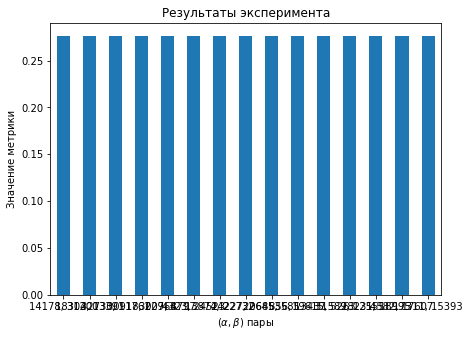

In [38]:
def plot_result_value(results):
    results['value_name'] = (results['params']['alpha'].astype(str)
                         .str.cat(results['params']['beta'].astype(str), sep=', '))
    
    plt.figure(figsize=(7, 5))
    ax = results['value'].plot(kind='bar', xticks=range(len(results)), rot=0)
    ax.set_xticklabels(results['value_name'].values)

    plt.xlabel(r'$(\alpha, \beta)$' + ' пары')
    plt.ylabel('Значение метрики')
    plt.title('Результаты эксперимента')

    plt.show()
    

plot_result_value(results)

In [39]:
%%time

best_recs = popular_scenario.production(
    best_params,
    df,
    users=None,
    items=None,
    user_features=None,
    item_features=None,
    k=10,
    context='no_context',
    to_filter_seen_items=True
)

31-Oct-19 12:38:07, root, DEBUG: Проверка датафреймов
31-Oct-19 12:38:07, root, DEBUG: Предварительная стадия обучения (pre-fit)
31-Oct-19 12:38:12, root, DEBUG: Среднее количество items у каждого user: 5.0
31-Oct-19 12:38:12, root, DEBUG: Основная стадия обучения (fit)
31-Oct-19 12:38:12, root, DEBUG: Проверка датафреймов
31-Oct-19 12:38:12, root, DEBUG: Выделение дефолтных юзеров
31-Oct-19 12:38:12, root, DEBUG: Выделение дефолтных айтемов
31-Oct-19 12:38:15, root, DEBUG: Количество items после фильтрации: 15


CPU times: user 44 ms, sys: 12 ms, total: 56 ms
Wall time: 8.34 s


In [40]:
best_recs.show(10)

+-------+---------+----------+--------------------+
|item_id|  user_id|   context|           relevance|
+-------+---------+----------+--------------------+
|   1040|100000982|no_context|0.013401378949242178|
|  12093|100000982|no_context|0.013286058126295864|
|  12087|100000982|no_context|0.012569213144671616|
|  12233|100000982|no_context| 0.01120464773950729|
|  12299|100000982|no_context|0.011162388656309532|
|   1066|100000982|no_context|0.010629989055715768|
|   1075|100000982|no_context|0.008618042905429467|
|  12180|100000982|no_context| 0.00858441474203717|
|   1034|100000982|no_context|0.008214103506591406|
|  12542|100000982|no_context|0.007975865416075723|
+-------+---------+----------+--------------------+
only showing top 10 rows



## Рекомендатель на основе k-NN для объектов (item k-NN based recommender) <a name='knn-recommender'></a>

### Запуск single модели <a name='knn-recommender-single'></a>

In [25]:
splitter = ValidationSchemes(spark)

train, test_input, test = splitter.log_split_by_date(
    df, test_start=datetime(2019, 8, 1),
    drop_cold_users=False, drop_cold_items=True
)

(
    train.count(), 
    test_input.count(), 
    test.count()
)

(42534961, 42534961, 16863084)

In [26]:
knn = KNNRecommender(spark, num_neighbours=15, shrink=0)

In [27]:
%%time

knn.fit(
    log=train,
    user_features=None,
    item_features=None,
    path=None
)

31-Oct-19 15:24:55, root, DEBUG: Проверка датафреймов
31-Oct-19 15:24:56, root, DEBUG: Предварительная стадия обучения (pre-fit)
31-Oct-19 15:24:56, root, DEBUG: Основная стадия обучения (fit)


CPU times: user 32 ms, sys: 0 ns, total: 32 ms
Wall time: 790 ms


In [28]:
%%time

recs = knn.predict(
    k=100,
    users=test.select('user_id').distinct(),
    items=test.select('item_id').distinct(),
    context='no_context',
    log=train,
    user_features=None,
    item_features=None,
    to_filter_seen_items=True,
    path=None
).cache()

31-Oct-19 15:24:56, root, DEBUG: Проверка датафреймов


CPU times: user 20 ms, sys: 4 ms, total: 24 ms
Wall time: 2.88 s


In [29]:
recs.show(5)

+-------+---------+--------------------+----------+
|item_id|  user_id|           relevance|   context|
+-------+---------+--------------------+----------+
|    196|100332107|0.001658969079728...|no_context|
|    433|100332107|0.001304757855092...|no_context|
|    439|100332107|0.001257416545453464|no_context|
|    373|100332107|0.001208028916289...|no_context|
|    844|100332107|0.001205568177416...|no_context|
+-------+---------+--------------------+----------+
only showing top 5 rows



In [30]:
%%time

metric = Metric.hit_rate_at_k(recs, test, k=100)
metric

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 38.7 s


0.07469469534974585

### Подбор гиперпараметров в item k-NN модели <a name='knn-recommender-scenario'></a>

In [16]:
knn_scenario = KNNScenario(spark)
knn_scenario.seed = 3951

In [18]:
%%time

knn_params_grid = {
    'num_neighbours': (40, 50, 1), 
    'shrink': [0]
}

best_params = knn_scenario.research(
    knn_params_grid,
    df,
    users=None, items=None,
    user_features=None,
    item_features=None,
    test_start=datetime(2019, 8, 1),
    test_size=0.35,
    k=20, context='no_context',
    to_filter_seen_items=True,
    n_trials=1, 
    n_jobs=1,
    how_to_split='by_date'
)

31-Oct-19 16:50:23, root, DEBUG: Деление на трейн и тест
31-Oct-19 16:50:36, root, DEBUG: Длина трейна и теста: (42534961, 8984804)
31-Oct-19 16:50:38, root, DEBUG: Количество юзеров в трейне и тесте: 10308614, 2597815
31-Oct-19 16:50:40, root, DEBUG: Количество айтемов в трейне и тесте: 1138, 281
31-Oct-19 16:50:40, root, DEBUG: Популярная модель: фит_предикт
31-Oct-19 16:50:40, root, DEBUG: Проверка датафреймов
31-Oct-19 16:50:40, root, DEBUG: Предварительная стадия обучения (pre-fit)
31-Oct-19 16:50:44, root, DEBUG: Среднее количество items у каждого user: 5.0
31-Oct-19 16:50:44, root, DEBUG: Основная стадия обучения (fit)
31-Oct-19 16:50:44, root, DEBUG: Проверка датафреймов
31-Oct-19 16:50:47, root, DEBUG: Количество items после фильтрации: 25
31-Oct-19 16:50:47, root, DEBUG: Модель KNN
31-Oct-19 16:50:47, root, DEBUG: Первый пре-фит модели
31-Oct-19 16:50:47, root, DEBUG: -------------
31-Oct-19 16:50:47, root, DEBUG: Начало оптимизации параметров
31-Oct-19 16:50:47, root, DEBUG:

CPU times: user 296 ms, sys: 84 ms, total: 380 ms
Wall time: 10min 45s


In [20]:
%%time

knn_params_grid = {
    'num_neighbours': (40, 50, 1), 
    'shrink': [0]
}

best_params = knn_scenario.research(
    knn_params_grid,
    df,
    users=None, items=None,
    user_features=None,
    item_features=None,
    test_start=datetime(2019, 8, 1),
    test_size=0.35,
    k=20, context='no_context',
    to_filter_seen_items=True,
    n_trials=1, 
    n_jobs=1,
    how_to_split='randomly'
)

31-Oct-19 17:16:36, root, DEBUG: Деление на трейн и тест
31-Oct-19 17:16:36, root, DEBUG: Длина трейна и теста: (42079893, 19773023)
31-Oct-19 17:16:38, root, DEBUG: Количество юзеров в трейне и тесте: 12386560, 6864018
31-Oct-19 17:16:38, root, DEBUG: Количество айтемов в трейне и тесте: 1411, 1349
31-Oct-19 17:16:38, root, DEBUG: Популярная модель: фит_предикт
31-Oct-19 17:16:38, root, DEBUG: Проверка датафреймов
31-Oct-19 17:16:38, root, DEBUG: Предварительная стадия обучения (pre-fit)
31-Oct-19 17:16:40, root, DEBUG: Среднее количество items у каждого user: 4.0
31-Oct-19 17:16:40, root, DEBUG: Основная стадия обучения (fit)
31-Oct-19 17:16:40, root, DEBUG: Проверка датафреймов
31-Oct-19 17:16:41, root, DEBUG: Количество items после фильтрации: 24
31-Oct-19 17:16:42, root, DEBUG: Модель KNN
31-Oct-19 17:16:42, root, DEBUG: Первый пре-фит модели
31-Oct-19 17:16:43, root, DEBUG: -------------
31-Oct-19 17:16:43, root, DEBUG: Начало оптимизации параметров
31-Oct-19 17:16:43, root, DEBU

CPU times: user 360 ms, sys: 128 ms, total: 488 ms
Wall time: 21min 43s


In [22]:
knn_results = knn_scenario.study.trials_dataframe()

knn_results.head()

number                state     value             datetime_start  \
                                                                     
0  0      TrialState.COMPLETE  0.000066 2019-10-30 09:47:22.917050   
1  1      TrialState.COMPLETE  0.000065 2019-10-30 09:48:44.040232   
2  2      TrialState.COMPLETE  0.000065 2019-10-30 09:51:37.878035   
3  3      TrialState.COMPLETE  0.000067 2019-10-30 09:52:16.067757   
4  4      TrialState.COMPLETE  0.000065 2019-10-30 09:52:38.988098   

           datetime_complete         params        system_attrs  
                             num_neighbours shrink      _number  
0 2019-10-30 09:48:44.036803  2.0            0      0            
1 2019-10-30 09:51:37.874329  9.0            0      1            
2 2019-10-30 09:52:16.064111  5.0            0      2            
3 2019-10-30 09:52:38.983023  10.0           0      3            
4 2019-10-30 09:53:00.744544  9.0            0      4